# Summary

This notebook contains high level, explorative, data analysis on the `mediawiki_page_change_v1` and `rc1_mediawiki_page_content_change` datasets.
For this analysis we set a sampling resolution of `1 day` period. We looked at a month of data between 2023-06-12 and 2023-07-12.

Key takeways:
 - `page_change_v1` shows stable throghput over time. We should be able to characterize "normal" traffic.
 - `rc1_mediawiki_page_content_change` contains spurious data (pipeline re-runs, duplicate events) that skews statistics.
 - processed time vs event time drift seems consistent with both behaviour. This issue is not related to these specific dataset, but should be investigated upstream.

Metric metrics we should consider for alerting on data quality regressions:
 - absolute number of processed events (consumed, produced, produced vs consumed).
 - rate of change (day to day) of processed events (consumed, produced, produced vs consumed).
 - day-to-day variation in rate of change of processed events (consumed, produced, produced vs consumed).
 - processed time vs events time drift (number of events with drift > 1 day per period).
 - error type distribution over time (TBD, not enough data).


In [34]:
!pip install polars fsspec requests seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 4.5 MB/s eta 0:00:0000:01


In [42]:
import wmfdata
import polars as pl
import pyarrow as pa
import json
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, to_date
sns.set_theme(style="ticks")
%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 10]

In [15]:
wmfdata.conda

<module 'wmfdata.conda' from '/home/gmodena/.conda/envs/2023-06-12T09.19.26_gmodena/lib/python3.10/site-packages/wmfdata/conda.py'>

In [16]:
session = wmfdata.spark.create_session() 

23/07/12 10:46:46 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
23/07/12 10:46:51 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Attempted to request executors before the AM has registered!
23/07/12 10:47:00 WARN DataSource: Found duplicate column(s) in the data schema and the partition schema: `datacenter`, `day`, `hour`, `month`, `year`


# Page change and page content change

The dataset is small. We can select everything and filter down.

In [410]:
start_date = "2023-06-12"
end_date = "2023-07-12"

In [413]:
page_content_change = session.sql(f"select wiki_id, to_date(dt) as event_time, to_date(meta.dt) as process_time from event.rc1_mediawiki_page_content_change where to_date(meta.dt) between '{start_date}' and '{end_date}'")

In [414]:
page_change = session.sql(f"select wiki_id, to_date(dt) as event_time, to_date(meta.dt) as process_time from event.mediawiki_page_change_v1 where to_date(meta.dt) between '{start_date}' and '{end_date}'")

In [415]:
page_change_df = (page_change
                  .groupby("process_time", "event_time")
                  .count()
                  .sort("process_time", "event_time")
                  .toPandas())

In [416]:
page_content_change_df = (page_content_change
                  .groupby("process_time", "event_time")
                  .count()
                  .sort("process_time", "event_time")
                  .toPandas())

### Page change

Overiew and trends in page_change_v1 data.

In [417]:
page_change_df.head(10)

process_time  event_time  count
0   2023-06-12  2004-08-05      1
1   2023-06-12  2004-09-03      1
2   2023-06-12  2004-12-18      5
3   2023-06-12  2004-12-19      9
4   2023-06-12  2004-12-21      3
5   2023-06-12  2004-12-26      1
6   2023-06-12  2004-12-31      1
7   2023-06-12  2005-01-12      1
8   2023-06-12  2005-02-10      1
9   2023-06-12  2005-02-15      1

In [418]:
page_change_process_time_df = page_change_df.groupby(["process_time"]).agg('sum')

<AxesSubplot: xlabel='process_time'>

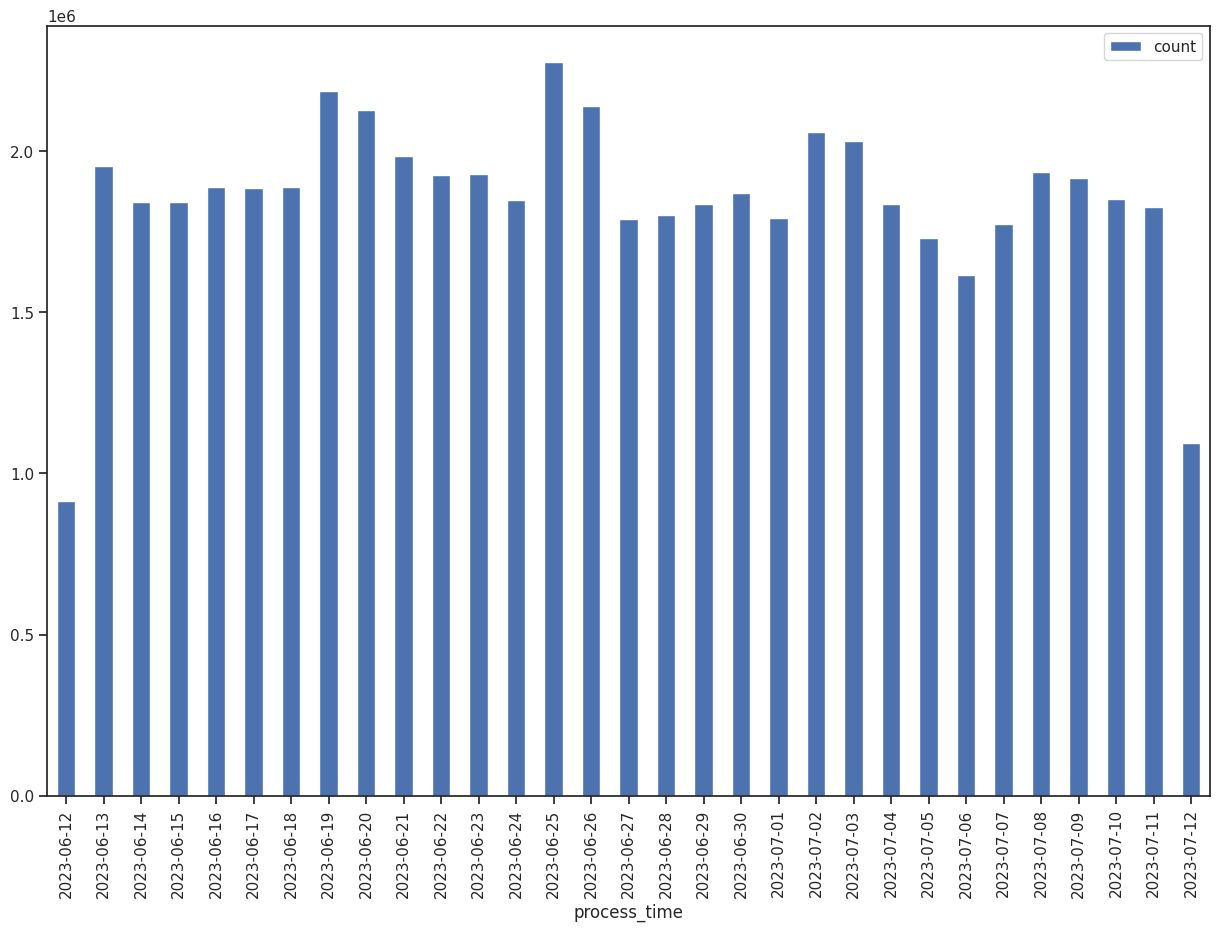

In [419]:
page_change_process_time_df.plot(kind="bar")

### Daily variation over time on a 3 days rolling average

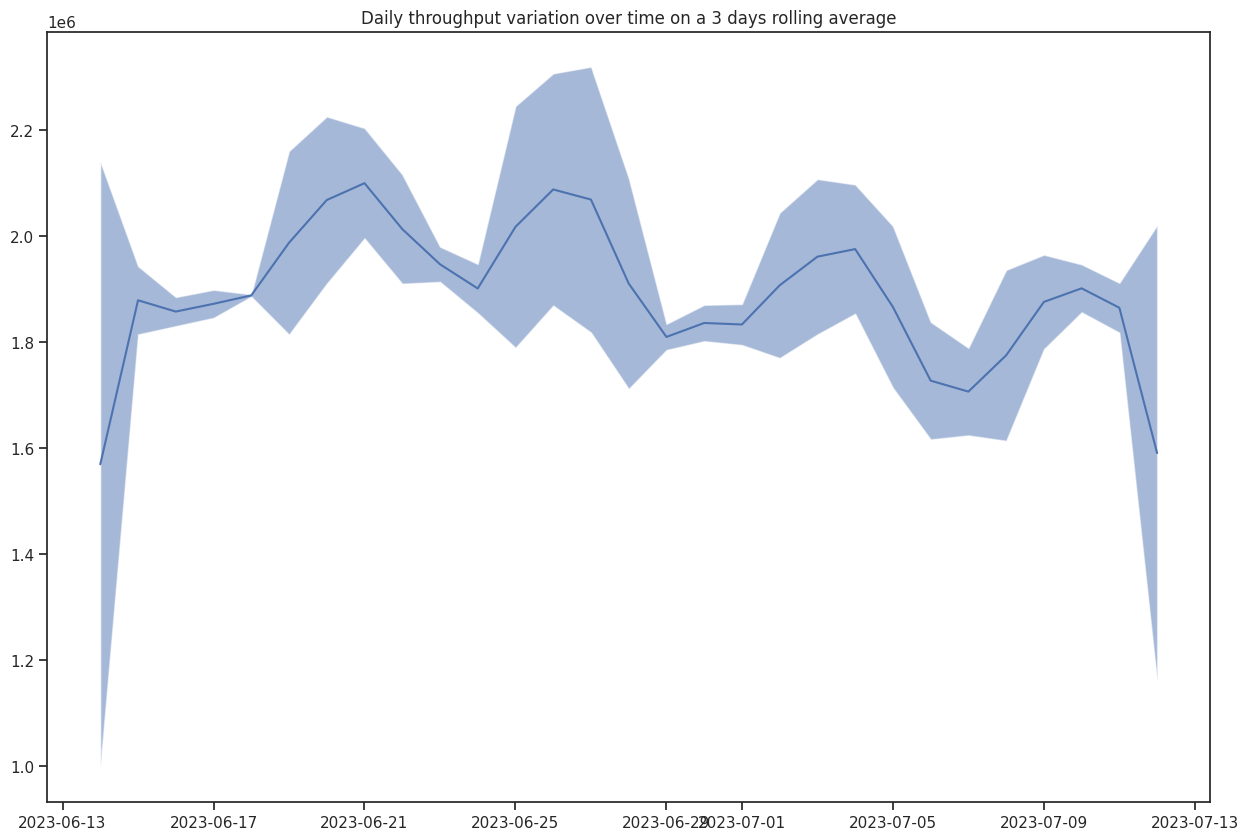

In [420]:
def plot_rolling_mean(df, window_size=3):
    y_mean = df.rolling(window_size).mean()
    y_std = df.rolling(window_size).std()
    plt.plot(y_mean)
    plt.fill_between(y_mean.index,
                     (y_mean - y_std).values.T[0],
                     (y_mean + y_std).values.T[0], alpha=.5)
    plt.title(f"Daily throughput variation over time on a {window_size} days rolling average")

plot_rolling_mean(page_change_process_time_df)

## Difference between event time and process time

Difference between consumed and produced records. See also timestamp drift for an analysis of deltas between process and event times.

<AxesSubplot: title={'center': 'page_change.v1: drifting events (> 1 day) per day'}, xlabel='process_time'>

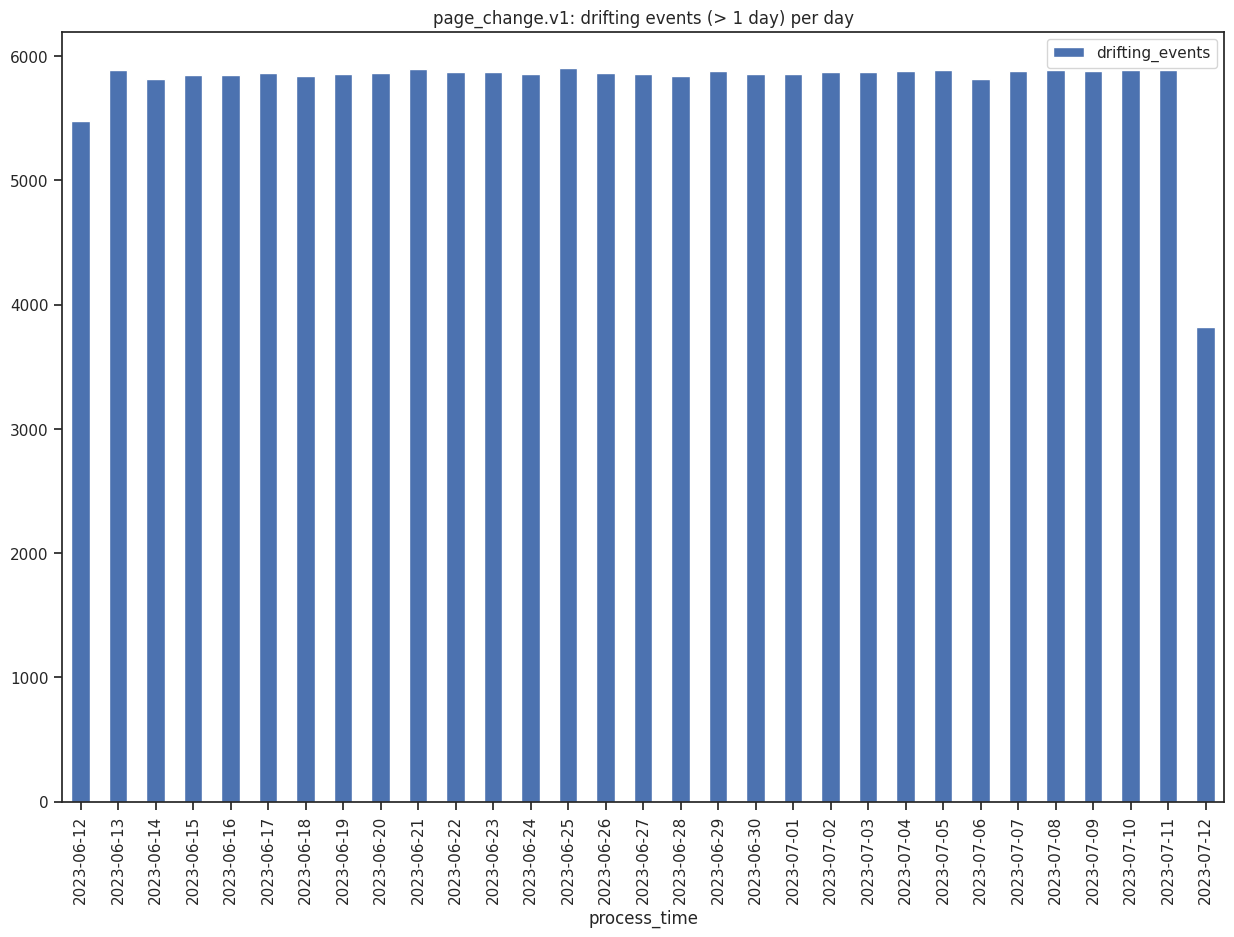

In [421]:
(page_change_df.groupby(["process_time"])
     .agg(drifting_events=("event_time", 'count'))
     .plot(kind='bar', title="page_change.v1: drifting events (> 1 day) per day")
)

In [422]:
from pyspark.sql.functions import lit
page_change_by_wiki_df = (page_change.filter("wiki_id" != lit("wikidatawiki"))
                  .select("wiki_id", "process_time", "event_time")
                  .groupby("wiki_id", "process_time", "event_time")
                  .count()
                  .sort("wiki_id", "process_time", "event_time", asc=False)
                  .toPandas())

In [423]:
drift_by_wiki = (page_change_by_wiki_df
     .groupby("wiki_id")
     .agg(drifting_events=('count', 'sum'))
     .sort_values("drifting_events", ascending=False))

In [424]:
drift_by_wiki['pct_drift'] = drift_by_wiki['drifting_events'] / page_change_by_wiki_df['count'].sum()

Distribution of events with timestamp drift (over all events with drift >1) 

In [438]:
drift_by_wiki['pct_drift'].mul(100).head(50)

wiki_id
wikidatawiki     34.763609
commonswiki      22.045535
enwiki           11.466124
ruwiki            3.655132
enwiktionary      3.154990
plwiki            1.550710
frwiki            1.512662
dewiki            1.413007
frwiktionary      1.191890
itwiki            1.174731
eswiki            1.113965
arwiki            0.931106
jawiki            0.896736
warwiki           0.829654
zhwiki            0.792506
svwiki            0.738040
cawiki            0.721307
mgwiktionary      0.670572
bgwiki            0.650774
fawiki            0.517156
minwiki           0.468566
metawiki          0.441008
viwiki            0.440076
ukwiki            0.425129
itwikisource      0.402395
nlwiki            0.398825
ptwiki            0.383439
zhwiktionary      0.382836
hewiki            0.319094
kowiki            0.303366
idwiki            0.297645
mediawikiwiki     0.229666
plwikinews        0.208081
bnwiki            0.199156
enwikisource      0.196315
trwiki            0.195347
cswiki            0.

<AxesSubplot: title={'center': 'Distribution of time drift (> 1 day) by wiki'}, xlabel='wiki_id'>

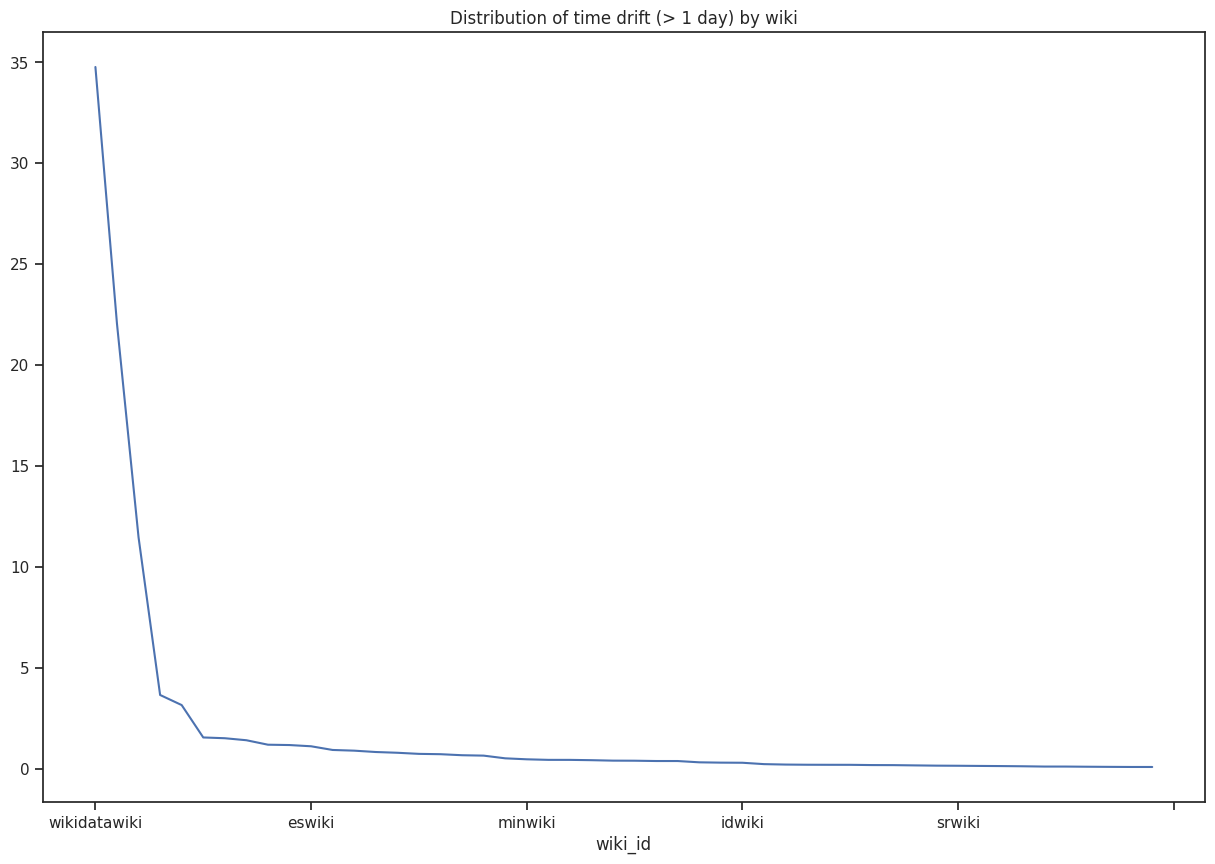

In [425]:
drift_by_wiki['pct_drift'].mul(100).head(50).plot(title="Distribution of time drift (> 1 day) by wiki")

## page_content_change

`rc1` contains spurious data and duplicate events. This section is provided as a reference and should be updated once the stream goes GA.

In [426]:
page_content_change_process_time_df = page_content_change_df.groupby(["process_time"]).agg('sum')

<AxesSubplot: xlabel='process_time'>

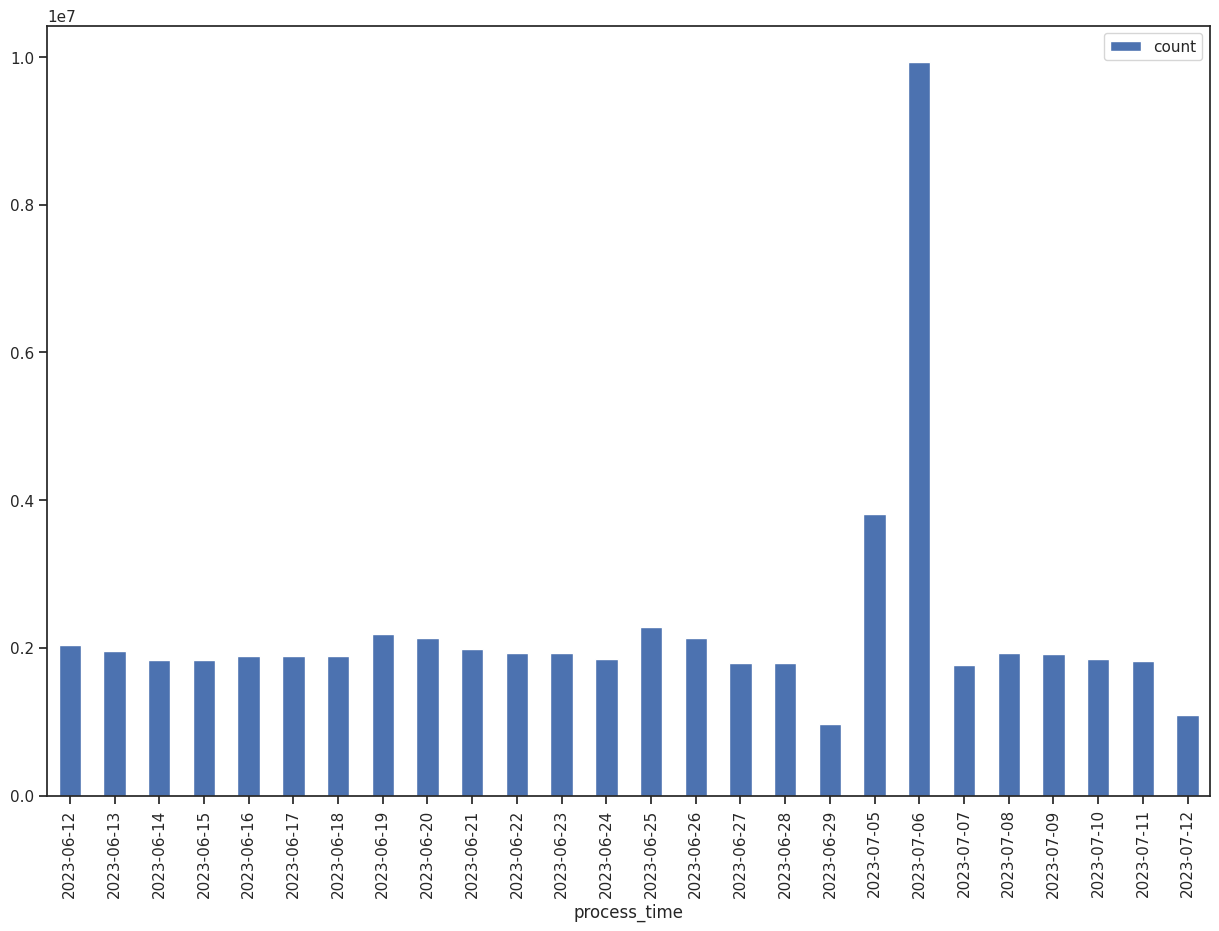

In [427]:
page_content_change_process_time_df.plot(kind="bar")

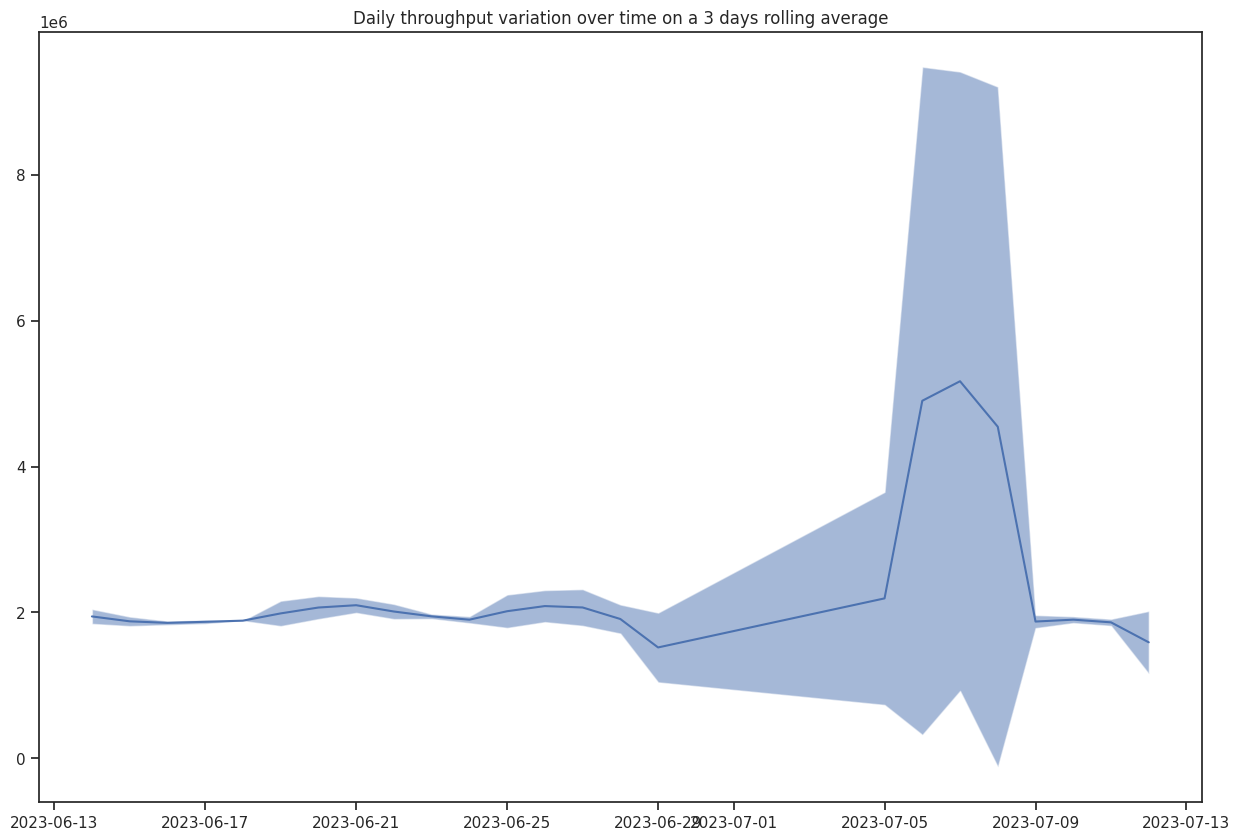

In [428]:
plot_rolling_mean(page_content_change_process_time_df)

In [429]:
events_df = page_change_process_time_df.join(page_content_change_process_time_df, lsuffix='_page_change', rsuffix='_page_content_change', how='inner')

In [430]:
page_change_process_time_df.shape[0] == events_df.shape[0]

False

<AxesSubplot: xlabel='process_time'>

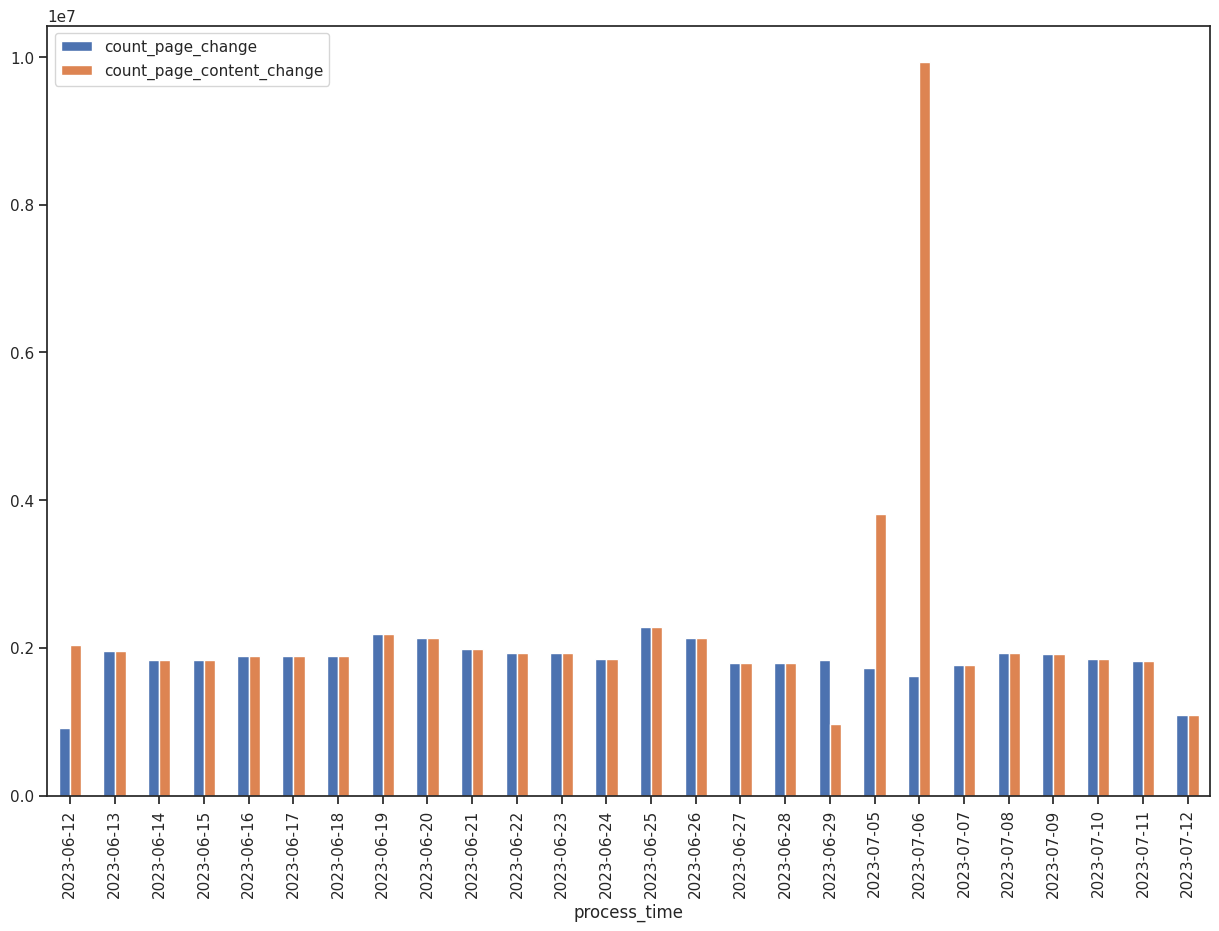

In [431]:
events_df.plot(kind='bar')

In [432]:
events_df["pct_change"] = events_df[["count_page_change", "count_page_content_change"]].pct_change(axis=1)["count_page_content_change"]

<AxesSubplot: title={'center': 'percent of change over time'}, xlabel='process_time'>

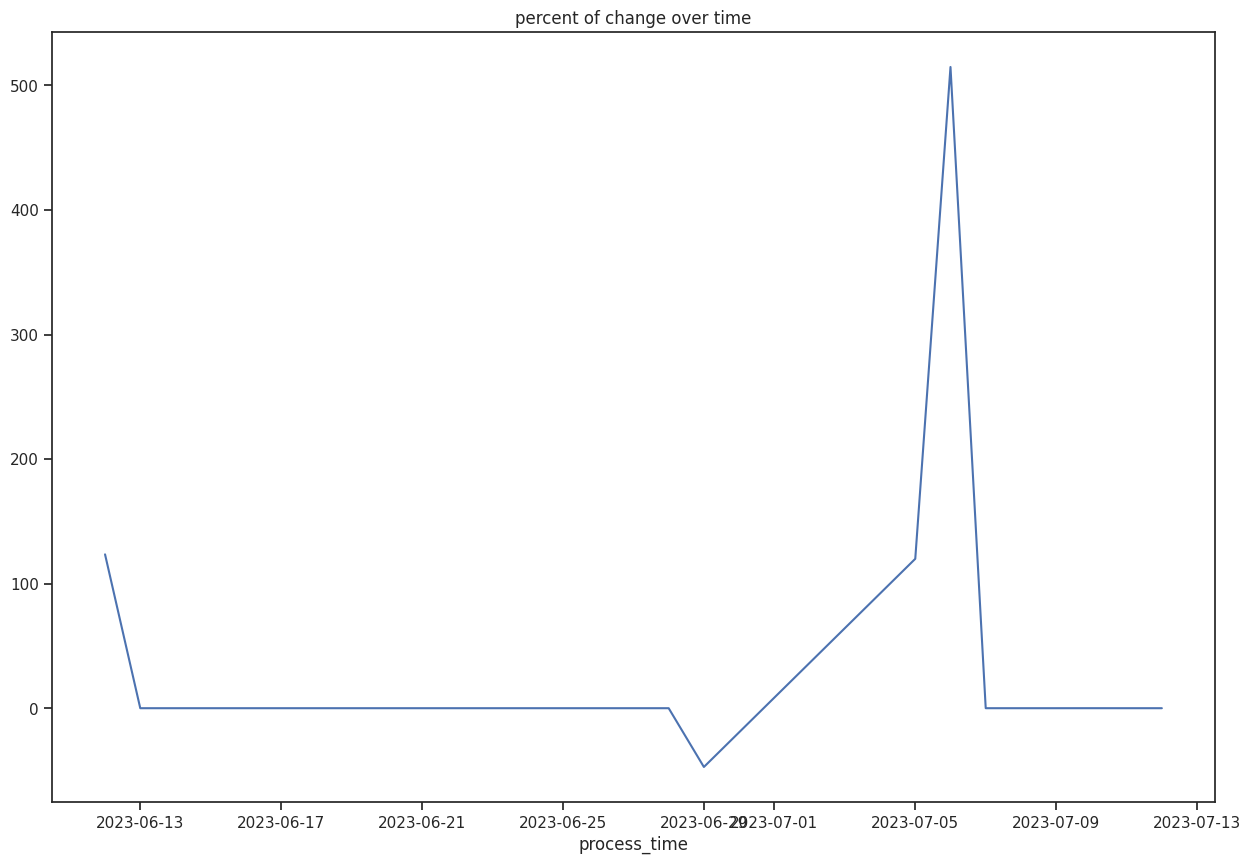

In [433]:
events_df["pct_change"].mul(100).plot(title="percent of change over time")

Calculate the rolling average percent of time

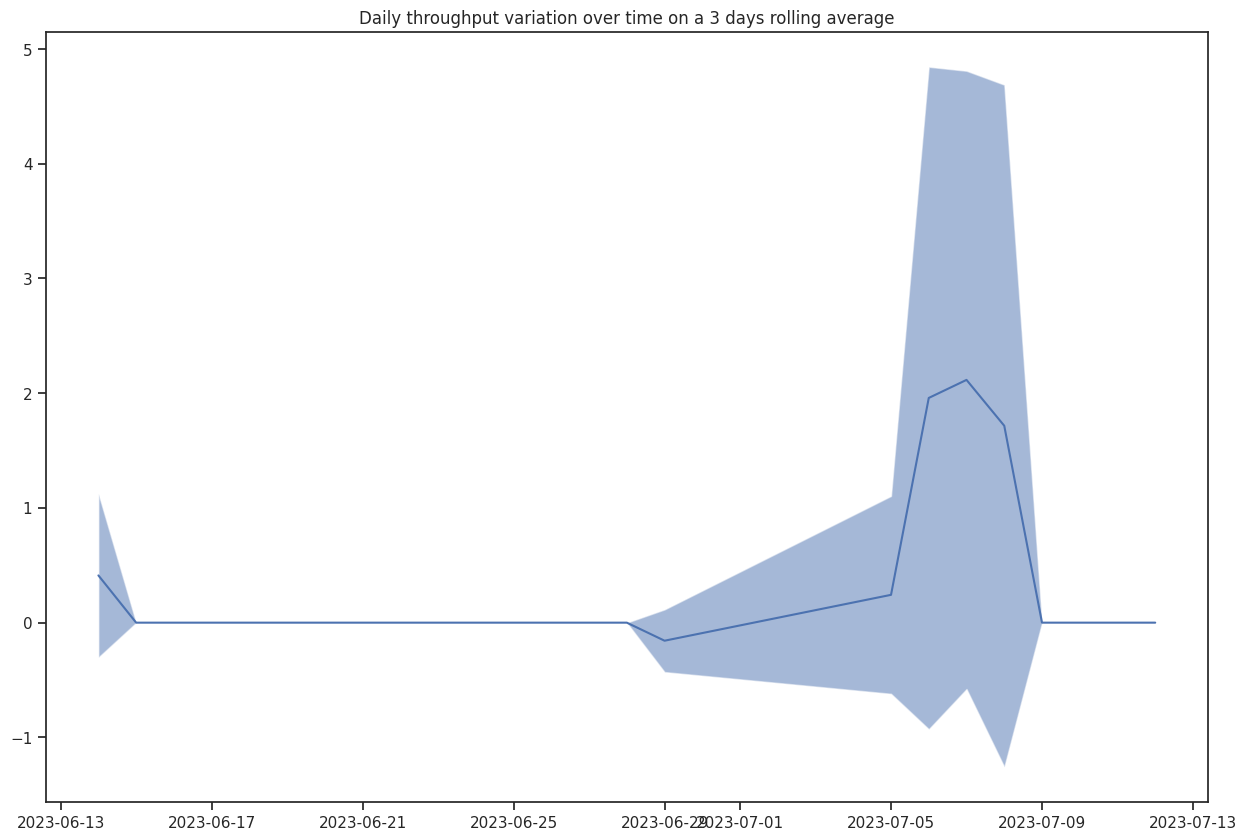

In [434]:
plot_rolling_mean(events_df[["pct_change"]])

<AxesSubplot: title={'center': 'Day-to-day variation in number processed events'}, xlabel='process_time'>

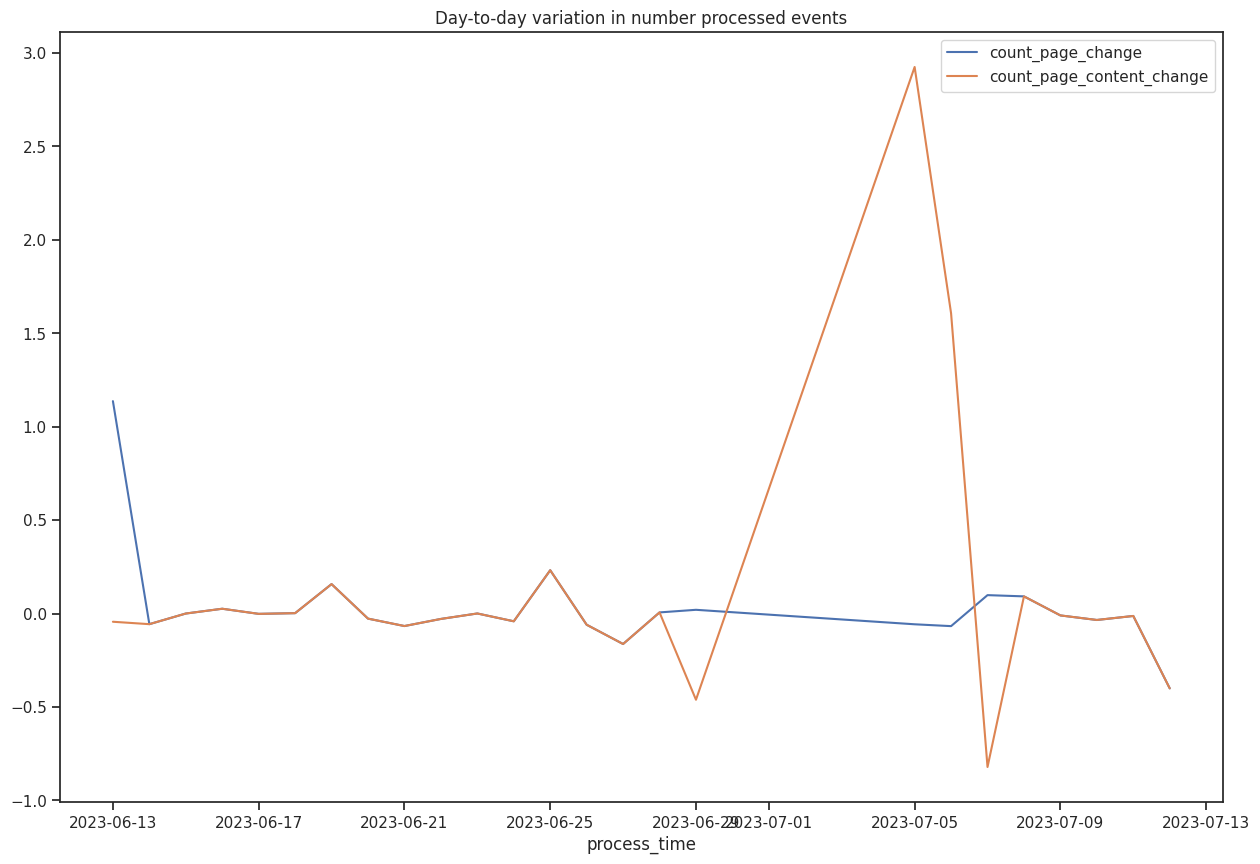

In [435]:
events_df[["count_page_change", "count_page_content_change"]].pct_change().plot(title="Day-to-day variation in number processed events")

<AxesSubplot: title={'center': 'Day-to-day variation in rate of change of processed events'}, xlabel='process_time'>

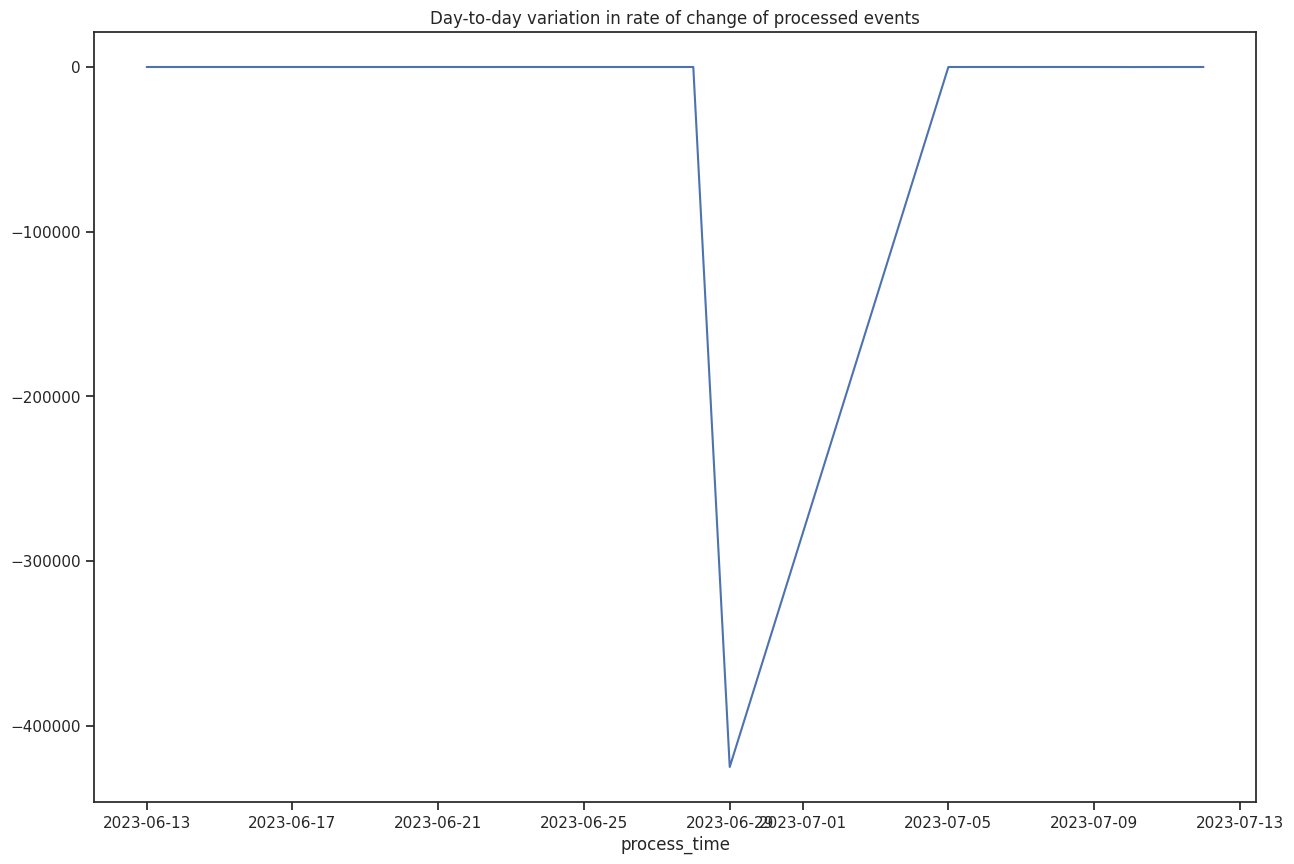

In [436]:
events_df["pct_change"].pct_change().plot(title="Day-to-day variation in rate of change of processed events")

# mw_page_content_change_enrich_error: error types distribution

Error type distribution by date. `error_type` has only been introduced recently (July 2023) and data is incomplete.

In [403]:
session.sql("SELECT error_type, count(*) from event.mw_page_content_change_enrich_error group by error_type").show()

23/07/12 18:38:25 WARN HiveExternalCatalog: The table schema given by Hive metastore(struct<_schema:string,dt:string,emitter_id:string,errored_schema_uri:string,errored_stream_name:string,message:string,meta:struct<domain:string,dt:string,id:string,request_id:string,stream:string,uri:string>,raw_event:string,stack:string,triggered_by:string,is_wmf_domain:boolean,normalized_host:struct<project_class:string,project:string,qualifiers:array<string>,tld:string,project_family:string>,error_type:string,datacenter:string,year:bigint,month:bigint,day:bigint,hour:bigint>) is different from the schema when this table was created by Spark SQL(struct<_schema:string,dt:string,emitter_id:string,errored_schema_uri:string,errored_stream_name:string,message:string,meta:struct<domain:string,dt:string,id:string,request_id:string,stream:string,uri:string>,raw_event:string,stack:string,triggered_by:string,is_wmf_domain:boolean,normalized_host:struct<project_class:string,project:string,qualifiers:array<strin

+--------------------+--------+
|          error_type|count(1)|
+--------------------+--------+
|                null|   73792|
|MediaWikiApiMissi...|       8|
+--------------------+--------+



# Timestamp drift

Measure timestamp drift between process time (`meta.dt`) and event time (`dt`). For details https://phabricator.wikimedia.org/T341134.

In [404]:
query = """
SELECT
    abs(to_unix_timestamp(to_timestamp(dt)) - to_unix_timestamp(to_timestamp(meta.dt)))/60/60/24/365 as drift_in_years,
    dt,
    meta.dt as meta_dt
FROM event.mediawiki_page_change_v1
ORDER BY drift_in_years DESC LIMIT 10;
"""

df = session.sql(query).show()

+------------------+--------------------+--------------------+
|    drift_in_years|                  dt|             meta_dt|
+------------------+--------------------+--------------------+
| 18.94295893581938|2004-08-05T13:55:41Z|2023-07-11T18:14:54Z|
| 18.94021391425672|2004-08-05T13:55:41Z|2023-07-10T18:12:07Z|
|18.937470668442415|2004-08-05T13:55:41Z|2023-07-09T18:10:16Z|
|18.934732749873163|2004-08-05T13:55:41Z|2023-07-08T18:11:13Z|
|18.931991533485537|2004-08-05T13:55:41Z|2023-07-07T18:10:26Z|
|18.929255866311518|2004-08-05T13:55:41Z|2023-07-06T18:12:34Z|
| 18.92651480847286|2004-08-05T13:55:41Z|2023-07-05T18:11:52Z|
|18.923774257990868|2004-08-05T13:55:41Z|2023-07-04T18:11:26Z|
| 18.92103421486555|2004-08-05T13:55:41Z|2023-07-03T18:11:16Z|
| 18.91829125443937|2004-08-05T13:55:41Z|2023-07-02T18:09:34Z|
+------------------+--------------------+--------------------+



In [405]:
query = """
with drift as (
SELECT
    abs(to_unix_timestamp(to_timestamp(dt)) - to_unix_timestamp(to_timestamp(meta.dt)))/60/60/24/365 as drift_in_years,
    dt,
    meta.dt as meta_dt
FROM event.mediawiki_page_change_v1
ORDER BY drift_in_years DESC
),

bins as (
  select
    floor(drift_in_years) as bin_floor,
    count(1) as count
  from drift
  group by 1
  order by 1
)

select
  bin_floor,
  bin_floor || ' - ' || (bin_floor + 1) as bin_range,
  count
from bins
order by 1;
"""

session.sql(query).show()

+---------+---------+--------+
|bin_floor|bin_range|   count|
+---------+---------+--------+
|        0|    0 - 1|54435313|
|        1|    1 - 2| 1110645|
|        2|    2 - 3|  454389|
|        3|    3 - 4|  376619|
|        4|    4 - 5|  189156|
|        5|    5 - 6|  155346|
|        6|    6 - 7|  239134|
|        7|    7 - 8|   75444|
|        8|    8 - 9|   66052|
|        9|   9 - 10|   42312|
|       10|  10 - 11|   41471|
|       11|  11 - 12|   43705|
|       12|  12 - 13|   35822|
|       13|  13 - 14|   45442|
|       14|  14 - 15|   37159|
|       15|  15 - 16|   24265|
|       16|  16 - 17|   24441|
|       17|  17 - 18|    4958|
|       18|  18 - 19|     925|
+---------+---------+--------+



In [406]:
query = """
with drift as (
SELECT
    abs(to_unix_timestamp(to_timestamp(rev_timestamp)) - to_unix_timestamp(to_timestamp(meta.dt)))/60/60/24/365 as drift_in_years,
    dt,
    meta.dt as meta_dt
FROM event.mediawiki_revision_create
ORDER BY drift_in_years DESC
),

bins as (
  select
    floor(drift_in_years) as bin_floor,
    count(1) as count
  from drift
  group by 1
  order by 1
)

select
  bin_floor,
  bin_floor || ' - ' || (bin_floor + 1) as bin_range,
  count
from bins
order by 1;
"""

session.sql(query).show()

23/07/12 18:38:51 WARN HiveExternalCatalog: The table schema given by Hive metastore(struct<comment:string,database:string,meta:struct<domain:string,dt:string,id:string,request_id:string,schema_uri:string,topic:string,uri:string,stream:string>,page_id:bigint,page_is_redirect:boolean,page_namespace:bigint,page_title:string,parsedcomment:string,performer:struct<user_edit_count:bigint,user_groups:array<string>,user_id:bigint,user_is_bot:boolean,user_registration_dt:string,user_text:string>,rev_content_changed:boolean,rev_content_format:string,rev_content_model:string,rev_id:bigint,rev_len:bigint,rev_minor_edit:boolean,rev_parent_id:bigint,rev_sha1:string,rev_timestamp:string,chronology_id:string,_schema:string,rev_is_revert:boolean,rev_revert_details:struct<rev_revert_method:string,rev_is_exact_revert:boolean,rev_reverted_revs:array<bigint>,rev_original_rev_id:bigint>,is_wmf_domain:boolean,normalized_host:struct<project_class:string,project:string,qualifiers:array<string>,tld:string,proje

+---------+---------+---------+
|bin_floor|bin_range|    count|
+---------+---------+---------+
|        0|    0 - 1|145272131|
|        1|    1 - 2|    85383|
|        2|    2 - 3|    56656|
|        3|    3 - 4|    39421|
|        4|    4 - 5|    32310|
|        5|    5 - 6|    30303|
|        6|    6 - 7|    26845|
|        7|    7 - 8|    24728|
|        8|    8 - 9|    24416|
|        9|   9 - 10|    30515|
|       10|  10 - 11|    39833|
|       11|  11 - 12|    50428|
|       12|  12 - 13|    39113|
|       13|  13 - 14|    46814|
|       14|  14 - 15|    37574|
|       15|  15 - 16|    38385|
|       16|  16 - 17|    39667|
|       17|  17 - 18|    19636|
|       18|  18 - 19|     8255|
|       19|  19 - 20|     2805|
+---------+---------+---------+
only showing top 20 rows



In [407]:
session.sql("select dt, meta from event.mediawiki_revision_create where dt is null limit 10").show()

23/07/12 18:39:03 WARN HiveExternalCatalog: The table schema given by Hive metastore(struct<comment:string,database:string,meta:struct<domain:string,dt:string,id:string,request_id:string,schema_uri:string,topic:string,uri:string,stream:string>,page_id:bigint,page_is_redirect:boolean,page_namespace:bigint,page_title:string,parsedcomment:string,performer:struct<user_edit_count:bigint,user_groups:array<string>,user_id:bigint,user_is_bot:boolean,user_registration_dt:string,user_text:string>,rev_content_changed:boolean,rev_content_format:string,rev_content_model:string,rev_id:bigint,rev_len:bigint,rev_minor_edit:boolean,rev_parent_id:bigint,rev_sha1:string,rev_timestamp:string,chronology_id:string,_schema:string,rev_is_revert:boolean,rev_revert_details:struct<rev_revert_method:string,rev_is_exact_revert:boolean,rev_reverted_revs:array<bigint>,rev_original_rev_id:bigint>,is_wmf_domain:boolean,normalized_host:struct<project_class:string,project:string,qualifiers:array<string>,tld:string,proje

+----+--------------------+
|  dt|                meta|
+----+--------------------+
|null|{ja.wikipedia.org...|
|null|{eu.wikipedia.org...|
|null|{www.wikidata.org...|
|null|{commons.wikimedi...|
|null|{commons.wikimedi...|
|null|{commons.wikimedi...|
|null|{it.wikipedia.org...|
|null|{www.wikidata.org...|
|null|{en.wikipedia.org...|
|null|{commons.wikimedi...|
+----+--------------------+



In [382]:
query = """
with drift as (
SELECT
    abs(to_unix_timestamp(to_timestamp(revision.rev_dt)) - to_unix_timestamp(to_timestamp(meta.dt)))/60/60/24/365 as drift_in_years,
    dt,
    meta.dt as rev_dt
FROM event.mediawiki_page_change_v1
ORDER BY drift_in_years DESC
),

bins as (
  select
    floor(drift_in_years) as bin_floor,
    count(1) as count
  from drift
  group by 1
  order by 1
)

select
  bin_floor,
  bin_floor || ' - ' || (bin_floor + 1) as bin_range,
  count
from bins
order by 1;
"""

session.sql(query).show()

+---------+---------+--------+
|bin_floor|bin_range|   count|
+---------+---------+--------+
|        0|    0 - 1|54325031|
|        1|    1 - 2| 1117479|
|        2|    2 - 3|  460622|
|        3|    3 - 4|  380938|
|        4|    4 - 5|  198852|
|        5|    5 - 6|  158741|
|        6|    6 - 7|  243972|
|        7|    7 - 8|   77810|
|        8|    8 - 9|   67795|
|        9|   9 - 10|   43855|
|       10|  10 - 11|   43507|
|       11|  11 - 12|   81415|
|       12|  12 - 13|   60604|
|       13|  13 - 14|   46645|
|       14|  14 - 15|   38110|
|       15|  15 - 16|   25471|
|       16|  16 - 17|   25146|
|       17|  17 - 18|    5421|
|       18|  18 - 19|    1103|
|       19|  19 - 20|      60|
+---------+---------+--------+
only showing top 20 rows



In [408]:
query = """
with drift as (
SELECT
    abs(to_unix_timestamp(to_timestamp(dt)) - to_unix_timestamp(to_timestamp(revision.rev_dt)))/60/60/24/365 as drift_in_years,
    dt,
    meta.dt as rev_dt
FROM event.mediawiki_page_change_v1
ORDER BY drift_in_years DESC
),

bins as (
  select
    floor(drift_in_years) as bin_floor,
    count(1) as count
  from drift
  group by 1
  order by 1
)

select
  bin_floor,
  bin_floor || ' - ' || (bin_floor + 1) as bin_range,
  count
from bins
order by 1;
"""

session.sql(query).show()

+---------+---------+--------+
|bin_floor|bin_range|   count|
+---------+---------+--------+
|        0|    0 - 1|57292316|
|        1|    1 - 2|    6834|
|        2|    2 - 3|    6233|
|        3|    3 - 4|    4319|
|        4|    4 - 5|    9696|
|        5|    5 - 6|    3395|
|        6|    6 - 7|    4838|
|        7|    7 - 8|    2366|
|        8|    8 - 9|    1743|
|        9|   9 - 10|    1543|
|       10|  10 - 11|    2036|
|       11|  11 - 12|   37710|
|       12|  12 - 13|   24782|
|       13|  13 - 14|    1203|
|       14|  14 - 15|     951|
|       15|  15 - 16|    1206|
|       16|  16 - 17|     705|
|       17|  17 - 18|     463|
|       18|  18 - 19|     178|
|       19|  19 - 20|      60|
+---------+---------+--------+
only showing top 20 rows



In [409]:
query = """
SELECT
    floor(abs(to_unix_timestamp(to_timestamp(dt)) - to_unix_timestamp(to_timestamp(meta.dt)))/60/60/24/365) as drift_in_years,
    page_change_kind,
    performer.is_bot,
    datacenter,
    count(*) as num_revisions
FROM event.mediawiki_page_change_v1
GROUP by performer.is_bot, page_change_kind, drift_in_years, datacenter
ORDER BY drift_in_years limit 100;
"""

df = session.sql(query).show()

+--------------+-----------------+------+----------+-------------+
|drift_in_years| page_change_kind|is_bot|datacenter|num_revisions|
+--------------+-----------------+------+----------+-------------+
|             0|             edit|  true|     eqiad|     29598630|
|             0|visibility_change| false|     eqiad|          742|
|             0|         undelete| false|     eqiad|         4122|
|             0|             move|  true|     eqiad|        23656|
|             0|visibility_change|  true|     eqiad|         1459|
|             0|         undelete|  true|     eqiad|           68|
|             0|             move| false|     eqiad|       151360|
|             0|           create| false|     eqiad|      2890017|
|             0|           create|  true|     eqiad|      1160999|
|             0|           delete|  true|     eqiad|        15270|
|             0|             edit| false|     eqiad|     20281392|
|             0|           delete| false|     eqiad|       307